In [1]:
import pygraphviz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch
import pygraphviz
import math

In [10]:
g = Graph("../Datasets/noname.dot")

plt.close()
[node for node, w in g.nodes['1'].out_neighbours]

In [2]:
class Node:
    def __init__(self, _id, number, color='green'):
        self.id = _id
        self.number = number
        self.in_neighbours = []
        self.out_neighbours = []
        self.circle = Circle(xy=np.zeros(2), radius = .1, color = color, alpha=.5, zorder=100)

    def add_out_neighbour(self, neighbour, weight=1):
        if neighbour not in self.out_neighbours:
            self.out_neighbours.append((neighbour, weight))

    def add_in_neighbour(self, neighbour, weight=1):
        if neighbour not in self.in_neighbours:
            self.in_neighbours.append((neighbour, weight))

    def has_neighbour(self,neighbour):
        if neighbour in [node for node,_ in self.out_neighbours]:
            return True
        if neighbour in [node for node,_ in self.in_neighbours]:
            return True
        else:
            return False
    def degree(self):
        return len(self.out_neighbours) + len(self.in_neighbours)

    def show_label(self, ax):
        ax.text(*self.circle.center, str(self.id), size=6, ha='center', va='baseline', alpha=.5)

class TreeNode(Node):
    def __init__(self, label, tree_dict=None):
        super().__init__(label)
        self.children = set()
        self.parent = None
        self.non_tree_neighbours = []
        self.width = None
        self.level = None
        self.height = None
        self.x_y_ratio = None

    @classmethod
    def build_tree_from_dict(cls, tree_dict):
        node_instances = {}

        def build_tree_helper(label):
            if label not in node_instances:
                node_instances[label] = TreeNode(label)

            node = node_instances[label]

            if label in tree_dict:
                for child, weight in tree_dict[label]:
                    child_node = build_tree_helper(child.id)
                    node.add_child(child_node, weight)

            return node

        root_label = next(iter(tree_dict))
        root_node = build_tree_helper(root_label)

        return root_node

    def add_child(self, child, weight=1):
        child.parent = self
        self.children.add((child, weight))

    def get_height(self):
        if not self.children:
            return 0
        self.height = 1 + max([child[0].get_height() for child in self.children])
        return self.height

    def compute_drawing_params(self):
        self.calculate_width()
        self.get_height()
        self.x_y_ratio = max((self.width//2) // self.height, self.height // (self.width//2))

    def get_level(self):
        self.level = 0
        current_parent = self.parent
        while current_parent:
            current_parent = current_parent.parent
            self.level += 1
        return self.level

    def calculate_width(self):
        self.width = 0
        children_widths = [child[0].calculate_width() for child in self.children]
        self.width = 1 + sum(children_widths)
        return self.width

    def compute_coordinates(self, x, y, x_y_ratio=1):
        self.coordinates = (x, y)
        if self.children:
            total_children_width = sum([child[0].width for child in self.children])
            starting_x = x - total_children_width // 2
            for child, _ in self.children:
                child_x = starting_x + child.width // 2
                child.compute_coordinates(child_x, 0 - child.get_level() * x_y_ratio, x_y_ratio)
                starting_x += child.width

    def draw_tree(self, labels=True, non_tree_edges=False):
        self.compute_drawing_params()
        self.compute_coordinates(0, 0, self.x_y_ratio)
        fig = plt.figure()
        ax = fig.gca()
        plt.axis(False)

        def draw_patch(node, ax):
            ax.add_patch(Circle(xy=node.coordinates, radius=0.5, color='green', alpha=0.3))
            if labels:
                plt.text(*node.coordinates, str(node.id), size=6, ha='center', va='baseline', alpha=0.5)
            if node.children:
                for child, _ in node.children:
                    ax.add_patch(ConnectionPatch(node.coordinates, child.coordinates, 'data', lw=0.5, color='grey'))
                    draw_patch(child, ax)
            if non_tree_edges:
                for nt_neighbour_label in node.non_tree_neighbours:
                    nt_neighbour_node = self.find_tree_node(nt_neighbour_label)
                    ax.add_patch(ConnectionPatch(node.coordinates, nt_neighbour_node.coordinates, 'data', lw=0.1, color='blue', linestyle=":"))

        draw_patch(self, ax)

        margin = 2
        x_lim = self.width // 2
        ax.set_xlim((-x_lim - margin, x_lim + margin))
        ax.set_ylim((-self.height * self.x_y_ratio - margin, 0 + margin))
        plt.grid(which='minor', axis='y', linewidth=0.5, linestyle=':')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)
        ax.tick_params(tick1On=False, which='both')
        ax.minorticks_on()
        plt.show()
        return fig

    def find_tree_node(self, label):
        queue = [self]
        while queue:
            current_node = queue.pop(0)
            if current_node.id == label:
                return current_node
            queue.extend([child[0] for child in current_node.children])

class Edge:
    def __init__(self, n1, n2, weight=1, directed=False):
        self.directed = directed
        self.node1, self.node2 = n1, n2
        self.circle1 = n1.circle
        self.circle2 = n2.circle
        self.inverted = False
        self.weight = weight
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='grey',zorder=1)

    def update_line(self, ax1=None, ax2=None, color="grey", coordsA='data', coordsB='data'):
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color)


In [121]:

class Graph:
    def __init__(self, incoming_dot_file=None, directed = False, subgraphs = False, a_subgraph = False, selected_subgraphs=None,weight_name="weight"):
        # directed graph
        self.directed = directed
        self.feedback_set = set()
        # graph nodes and edges
        self.nodes, self.edges = {}, {}
        if incoming_dot_file:
            self.load_graph(incoming_dot_file, subgraphs=subgraphs, selected_subgraphs=selected_subgraphs, weight_name=weight_name)

        # graph figure for visualisation
        self.fig = None if a_subgraph or subgraphs else plt.figure(figsize=(7,7))
        self.ax =  None if a_subgraph or subgraphs else self.fig.gca()
        self.axes = []
        self.min_max_x = np.array([0,1])
        self.min_max_y = np.array([0,1])

        # graph traversals
        self.dfs_order = []
        self.bfs_order= []
        # trees
        self.dfs_tree = {}
        self.bfs_tree = {}

    def load_graph(self, dot_file_path, subgraphs=False, selected_subgraphs=None,weight_name="weight"):
        G = pygraphviz.AGraph()
        G.read(dot_file_path)

        if subgraphs:
            self.subgraphs = {}
            for subgraph in G.subgraphs():
                if selected_subgraphs:
                    subgraph_name = subgraph.name
                    if subgraph_name in selected_subgraphs:
                        self.subgraphs[subgraph_name] = Graph(a_subgraph=True)

                        # nodes
                        for graphviz_node in subgraph.nodes():
                            node_id = graphviz_node.get_name()
                            node = Node(_id=node_id)
                            self.subgraphs[subgraph_name].nodes[node_id] = node
                else:
                    subgraph_name = subgraph.name
                    self.subgraphs[subgraph_name] = Graph(a_subgraph=True)
                    # nodes
                    for graphviz_node in subgraph.nodes():
                        node_id = graphviz_node.get_name()
                        node = Node(_id=node_id)
                        self.subgraphs[subgraph_name].nodes[node_id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]
                subgraph_name_1 = self.find_subgraph_for_node(node1_id)
                subgraph_name_2 = self.find_subgraph_for_node(node2_id)
                if selected_subgraphs:
                    if subgraph_name_1 in selected_subgraphs and subgraph_name_2 in selected_subgraphs:
                        edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id],directed=self.directed)
                        self.edges[(node1_id, node2_id)] = edge
                else:
                    edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id], directed=self.directed)
                    self.edges[(node1_id, node2_id)] = edge

        else:
            # nodes
            for i, graphviz_node in enumerate(G.nodes()):
                node = Node(_id=graphviz_node.get_name(),number=i)
                self.nodes[node.id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]

                weight = graphviz_edge.attr[weight_name] if weight_name in graphviz_edge.attr else None

                self.nodes[node1_id].add_out_neighbour(self.nodes[node2_id])
                self.nodes[node2_id].add_in_neighbour(self.nodes[node1_id])
                if self.directed:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight, directed=True)
                else:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight)
                self.edges[(node1_id, node2_id)] = edge

    def find_subgraph_for_node(self, node_id):
        for subgraph_name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return subgraph_name

    def add_node(self, node_id):
        self.nodes[node_id] = Node(node_id)

    def return_fig(self,labels=True,axis=True,subgraphs=False, title=None):
        print("Updating Figure")
        if subgraphs:
            for name, subgraph in self.subgraphs.items():
                subgraph.return_fig(title=name)
        else:
            node_radius = min(.1,(self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))

            for edge in self.edges.values():
                edge.update_line()
                edge.line.zorder=1
                self.ax.add_patch(edge.line)

            for node in self.nodes.values():
                #print(node.circle.center)
                node.circle.radius = node_radius
                node.circle.zorder = 10
                self.ax.add_patch(node.circle)
                if labels:
                    node.show_label(self.ax)


            x_lim = self.min_max_x + np.array([-node_radius,node_radius])
            y_lim = self.min_max_y + np.array([-node_radius,node_radius])
            self.ax.set_xlim(x_lim)
            self.ax.set_ylim(y_lim)
            self.ax.set_title(title)


            plt.axis(axis)

            return self.fig

    def update_ax(self, labels=True, axis=False, title=None, ax = None):
        print("Updating Figure")
        node_radius = min(.1, (self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))


        for node in self.nodes.values():
            node.circle.radius = node_radius
            ax.add_patch(node.circle)
            if labels:
                node.show_label(ax)
        x_lim = self.min_max_x + np.array([-(node_radius+.1), node_radius+.1])
        y_lim = self.min_max_y + np.array([-(node_radius+.1), node_radius+.1])
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title(title)

        ax.axis(axis)

    def return_subplots(self, labels=True, axis=False, title=None):

        num_subgraphs = len(self.subgraphs)
        num_cols = int(np.ceil(np.sqrt(num_subgraphs)))  # Number of columns based on square root of num_subgraphs

        # Adjust num_rows to ensure that num_cols * num_rows is greater than or equal to num_subgraphs
        num_rows = (num_subgraphs + num_cols - 1) // num_cols

        self.fig, self.axes = plt.subplots(num_rows, num_cols, figsize=(10, 8), sharex=True, sharey=True)

        for (name, subgraph), ax_sub in zip(self.subgraphs.items(), self.axes.flatten()):
            subgraph.update_ax(labels=labels, axis=axis, title=name, ax=ax_sub)
            ax_sub.set_aspect('equal')
             # Draw bounding box around the subgraph
            min_x, max_x = ax_sub.get_xlim()
            min_y, max_y = ax_sub.get_ylim()
            bbox = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor="green", facecolor='none')
            ax_sub.add_patch(bbox)

            for edge in self.edges.values():
                node1_id, node2_id = edge.node1.id, edge.node2.id
                subgraph1 = self.find_subgraph_containing_node(node1_id)
                subgraph2 = self.find_subgraph_containing_node(node2_id)
                if subgraph1 is not None and subgraph2 is not None and subgraph1 != subgraph2:
                    # Draw connection between subgraphs
                    ax1 = self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph1)]
                    ax2 = self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph2)]
                    edge.update_line(ax1=ax1,ax2=ax2,color="red",coordsA='data',coordsB='data')
                    ax_sub.add_patch(edge.line)
                else:
                    edge.update_line()
                    ax=self.axes.flatten()[list(self.subgraphs.keys()).index(subgraph1)]
                    ax.add_patch(edge.line)
        #plt.tight_layout()
        plt.suptitle(title, y=1.02)
        plt.show()

    def find_subgraph_containing_node(self, node_id):
        for name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return name
        return None

    def circular_layout(self, center=(.5,.5), radius=.5, subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.circular_layout()
        N = len(self.nodes)
        cx, cy = center
        i = 0
        for node in self.nodes.values():
            angle = 2* np.pi * i / N
            x = cx + radius * np.cos(angle)
            y = cy + radius * np.sin(angle)
            node.circle.center = np.array([x,y])
            i += 1

    def random_layout(self, x_range=(0.0, 1.0), y_range=(0.0, 1.0), subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.random_layout()
        for node in self.nodes.values():
            x = np.random.uniform(x_range[0], x_range[1])
            y = np.random.uniform(y_range[0], y_range[1])
            node.circle.center = np.array([x,y])

    def dfs(self, root):
        visited = set()
        self.dfs_order = []
        self.dfs_tree = {root: []}
        def dfs_recursive(node_id):
            visited.add(node_id)
            self.dfs_order.append(node_id)
            for neighbour in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    self.dfs_tree[node_id].append(neighbour)
                    self.dfs_tree[neighbour.id] = []
                    dfs_recursive(neighbour.id)
        dfs_recursive(root)

    def bfs(self, root):
        visited = set()
        self.bfs_order = []
        self.bfs_tree = {root: []}
        queue = deque([root])

        while queue:
            node_id = queue.popleft()
            if node_id in visited:
                continue
            visited.add(node_id)
            self.bfs_order.append(node_id)

            for neighbour in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    self.bfs_tree[node_id].append(neighbour.id)
                    self.bfs_tree[neighbour] = []
                    queue.append(neighbour.id)

    def force_directed_graph(self, embedder_type="Eades", K=500, epsilon=1e-5, delta=.001, c=.9,c_rep=1,c_spring=2, subgraphs=False):
        print("force directed graph computation")
        l = c * 1  # ideal edge length

        def repulsive_force(distance):
            if embedder_type == "Fruchterman & Reingold":
                return (l**2 / distance)
            if embedder_type == "Eades":
                return c_rep / (distance**2)

        def attractive_force(distance):
            if embedder_type == "Fruchterman & Reingold":
                return (distance**2 / l)
            if embedder_type == "Eades":
                return c_spring * np.log(distance / l)

        if subgraphs:
            for subgraph in self.subgraphs.values():
                    subgraph.force_directed_graph()

        for _ in range(K):
            displacement = {v: np.zeros(2) for v in self.nodes.keys()}

            # calculate repulsive forces
            for key_u, u in self.nodes.items():
                for v in self.nodes.values():
                    if u != v and not u.has_neighbour(v):
                        diff = u.circle.center - v.circle.center
                        distance = np.linalg.norm(diff)
                        if distance > 0:
                            r_force = repulsive_force(distance)
                            displacement[key_u] += r_force * (diff/delta) # delta is normalized

            # calculate attractive forces
            for key_u, u in self.nodes.items():
                for key_v, v in self.nodes.items():
                    if u.has_neighbour(v):
                        diff = u.circle.center - v.circle.center
                        distance = np.linalg.norm(diff)
                        if distance > 0:
                            a_force = attractive_force(distance)
                            displacement[key_u] += a_force * (diff/distance) # delta is normalized

            # update positions
            for key_v, v in self.nodes.items():
                length = np.linalg.norm(displacement[key_v])
                if length > 0:
                    # displacement vector is normalized
                    v.circle.center += delta * displacement[key_v] / length
                    self.min_max_x = np.array([min(v.circle.center[0],self.min_max_x[0]),
                                               max(v.circle.center[0],self.min_max_x[1])])
                    self.min_max_y = np.array([min(v.circle.center[1],self.min_max_y[0]),
                                               max(v.circle.center[1],self.min_max_y[1])])

            max_displacement = max(np.linalg.norm(disp) for disp in displacement.values()) if displacement.values() else 0

            if max_displacement < epsilon:
                break

    def remove_cycles(self):
        order = []
        self.feedback_set = set()
        for node_id in sorted(self.nodes.keys(), key=lambda x: int(x)):
            node = self.nodes[node_id]
            order.append(node_id)
            for neighbour in node.out_neighbours:
                if neighbour.id in order:
                    # inverse edge direction in node
                    node.out_neighbours.remove(neighbour)
                    node.in_neighbours.append(neighbour)
                    # inverse edge direction in neighbour
                    neighbour.in_neighbours.remove(node)
                    neighbour.out_neighbours.append(node)
                    # inverse edge
                    self.edges[(node_id,neighbour.id)].invert()
                    self.feedback_set.add(self.edges[(node_id,neighbour.id)])

    def heuristic_with_guarantees(self):
        edges_to_reverse = set()

        while len(self.nodes) > 0:
            sinks = [node for node in self.nodes.values() if len(node.in_neighbours) > 0 and len(node.out_neighbours) == 0]
            for sink in sinks:
                for in_n in sink.in_neighbours:
                    edges_to_reverse.add((in_n, sink))
                self.remove_node(sink)

            isolated_nodes = [isolate for isolate in self.nodes.values() if len(isolate.in_neighbours) + len(isolate.out_neighbours) == 0]
            for isolate in isolated_nodes:
                self.remove_node(isolate)

            sources = [node for node in self.nodes.values() if len(node.out_neighbours) > 0 and len(node.in_neighbours) == 0]
            for source in sources:
                for out_n in source.out_neighbours:
                    edges_to_reverse.add((out_n, source))
                self.remove_node(source)

            # If graph is non-empty, select a node with max |N_outgoing| - |N_incoming|
            if len(self.nodes) > 0:
                node = max(self.nodes.values(), key=lambda node: len(node.in_neighbours) - len(node.out_neighbours))
                for out_n in node.out_neighbours:
                    edges_to_reverse.add((out_n, node))
                self.remove_node(node)

        return edges_to_reverse

    def remove_node(self, node):
        for neighbour in node.out_neighbours:
            neighbour.in_neighbours.remove(node)
        for neighbour in node.in_neighbours:
            neighbour.out_neighbours.remove(node)
        del self.nodes[node.id]

    def has_cycle(self):
        visited = set()
        recursion_stack = set()

        def dfs(node_id):
            if node_id in recursion_stack:
                return True
            if node_id in visited:
                return False
            visited.add(node_id)
            recursion_stack.add(node_id)
            for neighbour in self.nodes[node_id].out_neighbours:
                if dfs(neighbour.id):
                    return True
            recursion_stack.remove(node_id)
            return False

        for node in self.nodes:
            if dfs(node):
                return True
        return False

    def topological_sort(self):
        # Dictionary to store in-degrees of nodes
        in_degrees = {node_id: 0 for node_id in self.nodes}

        # Calculate in-degrees of nodes
        for node_id, node in self.nodes.items():
            for neighbour in node.out_neighbours:
                in_degrees[neighbour.id] += 1

        # Queue for nodes with no incoming edges
        queue = deque([node_id for node_id, in_degree in in_degrees.items() if in_degree == 0])

        # Topologically sorted nodes
        sorted_nodes = []

        # Perform topological sorting
        while queue:
            node_id = queue.popleft()
            sorted_nodes.append(node_id)

            # Reduce in-degree of neighbours
            for neighbour in self.nodes[node_id].out_neighbours:
                in_degrees[neighbour.id] -= 1

                # Add neighbour to queue if its in-degree becomes 0
                if in_degrees[neighbour.id] == 0:
                    queue.append(neighbour.id)

        return sorted_nodes

    def assign_layers(self):
        # Perform topological sort to get node order
        node_order = self.topological_sort()

        # Dictionary to store layer assignments
        layer_assignments = {node_id: 0 for node_id in self.nodes}

        # Assign layers based on topological order
        for node_id in node_order:
            node = self.nodes[node_id]
            if node.in_neighbours:
                max_predecessor_layer = max(layer_assignments[predecessor.id] for predecessor in node.in_neighbours)
            else:
                max_predecessor_layer = 0
            layer_assignments[node_id] = max_predecessor_layer + 1

        # Update layer attribute of nodes
        for node_id, layer in layer_assignments.items():
            self.nodes[node_id].layer = layer

        return layer_assignments

    def distances_matrix(self):
        N = len(self.nodes)
        D = np.ones((N,N)) * 10000
        numbered_nodes = {node.number:node for node in self.nodes.values()}
        numbered_edges = {(edge.node1.number, edge.node2.number): edge for edge in self.edges.values()}
        for (i,j), edge in numbered_edges.items():
            D[i,j] = int(edge.weight) if edge.weight else 1 # if no weights give path vlalue
            D[j, i] = D[i,j] # symmetry!

        #self loop
        for i in range(N):
            D[i, i] = 0

        for k, knode in numbered_nodes.items():
            for i, inode in numbered_nodes.items():
                for j, jnode in numbered_nodes.items():
                    if D[i,j] > D[i,k] + D[k,j]:
                        D[i,j] = D[i,k] + D[k,j]
                        D[j, i] = D[i, j] # symmetry!
        return D

# STEP 3 FORCE DIRECTED GRAPHS
    def repulsive_forces(self, k):  #k is C_rep
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for u_id, u in self.nodes.items():
            for v in self.nodes.values():
                if u != v and not u.has_neighbour(v):
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta)
                    if distance > 0:
                        repulsive_force = k / distance**2
                        forces[u_id] += repulsive_force * (delta / distance) #delta is normalized
        return forces

    def spring_forces(self, k, optimal_length): #k is C_spring

        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}

        for u_id, u in self.nodes.items():
            for v in self.nodes.values():
                if u.has_neighbour(v):
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta)
                    if distance > 0:
                        spring_force_magnitude = k * np.log(distance / optimal_length)
                        spring_force = spring_force_magnitude * (delta / distance)
                        forces[u_id] += spring_force

        return forces

    def spring_embedder(self, k_rep=1, k_spring=2, optimal_length=1, iterations=100, threshold=1e-5, delta=.001):

        t = 1
        while t <= iterations:
            rep_forces = self.repulsive_forces(k_rep)
            spr_forces = self.spring_forces(k_spring, optimal_length)

            net_force = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}  # Initialize net forces

            for node_id, node in self.nodes.items():
                net_force[node_id] = rep_forces[node_id] + spr_forces[node_id]

            for node_id, node in self.nodes.items():
                self.nodes[node_id].circle.center += delta * net_force[node_id]

                self.min_max_x = np.array([min(node.circle.center[0],self.min_max_x[0]),
                                               max(node.circle.center[0],self.min_max_x[1])])
                self.min_max_y = np.array([min(node.circle.center[1],self.min_max_y[0]),
                                               max(node.circle.center[1],self.min_max_y[1])])

            max_force = max(np.linalg.norm(force) for force in net_force.values())
            if max_force < threshold:
                break

            t += 1

    def repulsive_forces_1(self, ideal_edge_length):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for u_id,u in self.nodes.items():
            for v in self.nodes.values():
                if u != v:  # Exclude self-repulsion
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
                    repulsive_force = ideal_edge_length**2 / distance
                    forces[u_id] += repulsive_force * (delta / distance)
        return forces

    def attractive_forces_1(self, ideal_edge_length, mass_bool=False):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        if mass_bool:
            masses = {node_id: 1 + node.degree() / 2 for node_id,node in self.nodes.items()}  # Calculate node mass**1

        for u_id, v_id in self.edges.keys():  # Only iterate over edges
            delta = np.array(self.nodes[v_id].circle.center) - np.array(self.nodes[u_id].circle.center)
            distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
            spring_force_magnitude = (distance**2 / ideal_edge_length) / masses[u_id] if mass_bool else distance**2 / ideal_edge_length
            # Feedback: Instead of updating the forces array, store the force in a separate variable
            force = spring_force_magnitude * (delta / distance)
            forces[u_id] += force
            forces[v_id] -= force # Apply equal and opposite force
        return forces

    def calculate_spring_forces(self, rep_forces, attr_forces):
        spring_forces = {node_id: rep_forces[node_id] for node_id in self.nodes.keys()}
        for u_id, v_id in self.edges.keys():
            spring_forces[u_id] += attr_forces[u_id]
            spring_forces[v_id] += attr_forces[v_id]
        return spring_forces

    def magnetic_forces(self, magnetic_constant):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        field_direction = np.array([0, 1])  # use [1, 0] for a horizontal field

        for u, v in self.edges.keys():
            delta = np.array(self.nodes[v].circle.center) - np.array(self.nodes[u].circle.center)
            edge_direction = delta / (np.linalg.norm(delta) + 1e-6)
            cos_theta = np.dot(edge_direction, field_direction)
            angle = np.arccos(np.clip(cos_theta, -1, 1))
            magnetic_force_magnitude = magnetic_constant * (1 - cos_theta)
            # Calculate perpendicular direction to the edge direction to apply force
            perpendicular_dir = np.array([-edge_direction[1], edge_direction[0]])
            magnetic_force = magnetic_force_magnitude * perpendicular_dir

            forces[u] += magnetic_force
            forces[v] -= magnetic_force
        return forces

    def gravitational_forces(self, center_point, gravitational_constant):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for node_id, node in self.nodes.items():
            delta = center_point - np.array(node.circle.center)

            distance = np.linalg.norm(delta)
            grav_force = gravitational_constant * delta
            forces[node_id] += grav_force / distance if distance > 0 else 0
        return forces

    def spring_embedder_f(self, ideal_length=.1, K=100, epsilon=1e-4, delta=.1, gravitational_constant=None, magnetic_constant=None):
            center_point = np.array([0.5, 0.5])
            t = 0
            cooling_factor = 0.95
            min_delta = 0.00001

            while t < K:
                rep_forces = self.repulsive_forces_1(ideal_length)
                attr_forces = self.attractive_forces_1(ideal_length)
                grav_forces = self.gravitational_forces(center_point, gravitational_constant) if gravitational_constant else {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()} #Gravity
                mag_forces = self.magnetic_forces(magnetic_constant) if magnetic_constant else {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()} #magnetic



                for node_id, node in self.nodes.items():
                    net_force = rep_forces[node_id] + attr_forces[node_id] + grav_forces[node_id] + mag_forces[node_id] #+gravity/magnetic

                    displacement = np.clip(delta * net_force, -delta, delta)
                    node.circle.center += displacement
                    self.min_max_x = np.array([min(node.circle.center[0],self.min_max_x[0]),
                                                max(node.circle.center[0],self.min_max_x[1])])
                    self.min_max_y = np.array([min(node.circle.center[1],self.min_max_y[0]),
                                                max(node.circle.center[1],self.min_max_y[1])])

                delta = max(min_delta, cooling_factor * delta)

                max_force = max(np.linalg.norm(node.circle.center) for node in self.nodes.values())
                if max_force < epsilon:
                    break

                t += 1


    ### STEP 4 LAYERED LAYOUT
    def feedback_arc_set(self):

        import copy
        self_copy = copy.copy(self)
        processed_edges = set()
        fas = set()

        while True:
            try:
                cycle = self_copy.find_cycle()
            except Exception:
                break

            cycle_edge_counts = {}
            for edge in cycle:
                u_id, v_id = edge
                if (u_id, v_id) in processed_edges:
                    continue

                self_copy.remove_edge(u_id,v_id)
                print("removed ", (u_id,v_id), f"len = {len(self_copy.edges)}")
                cycle_edge_counts[(u_id,v_id)] = self_copy.count_cycles()
                self_copy.add_edge(u_id,v_id)
                processed_edges.add((u_id, v_id)
                print("added ", (u_id,v_id), "len ",len(self_copy.edges),"\n")

            edge_to_remove = max(cycle_edge_counts, key=cycle_edge_counts.get)
            self_copy.remove_edge(*edge_to_remove)
            fas.add(edge_to_remove)

        return fas



    def find_cycle(self, source=None, orientation=None):
        explored = set()
        cycle = []

        def tailhead(edge):
            return edge[:2]

        final_node = None
        for start_node in self.nodes.values():
            if start_node.id in explored:
                continue

            edges = []
            seen = {start_node.id}
            active_nodes = {start_node.id}
            previous_head = None

            for edge in self.edge_dfs(start_node.id):
                tail, head = tailhead(edge)
                if head in explored:
                    continue
                if previous_head is not None and tail != previous_head:
                    while True:
                        try:
                            popped_edge = edges.pop()
                        except IndexError:
                            edges = []
                            active_nodes = {tail}
                            break
                        else:
                            popped_head = tailhead(popped_edge)[1]
                            active_nodes.remove(popped_head)

                        if edges:
                            last_head = tailhead(edges[-1])[1]
                            if tail == last_head:
                                break
                edges.append(edge)

                if head in active_nodes:
                    cycle.extend(edges)
                    final_node = head
                    break
                else:
                    seen.add(head)
                    active_nodes.add(head)
                    previous_head = head

            if cycle:
                break
            else:
                explored.update(seen)

        if not cycle:
            raise Exception("No cycle found")

        for i, edge in enumerate(cycle):
            tail, head = tailhead(edge)
            if tail == final_node:
                break

        return cycle[i:]

    def edge_dfs(self, start_node_id):
        visited = set()
        stack = [(start_node_id, iter(self.nodes[start_node_id].out_neighbours))]

        while stack:
            parent, children = stack[-1]
            try:
                child_id = next(children)[0].id
                if child_id not in visited:
                    visited.add(child_id)
                    yield (parent, child_id)
                    stack.append((child_id, iter(self.nodes[child_id].out_neighbours)))
            except StopIteration:
                stack.pop()

    def count_cycles(self):
        visited = set()
        cycle_count = 0

        # Depth-first search function to traverse the graph
        def dfs(node_id, start_node_id, path):
            nonlocal cycle_count
            visited.add(node_id)
            for neighbour in self.nodes[node_id].out_neighbours:
                neighbour_id = neighbour[0].id
                if neighbour_id == start_node_id and len(path) > 2:
                    cycle_count += 1
                elif neighbour_id not in visited:
                    dfs(neighbour_id, start_node_id, path + [neighbour_id])
            visited.remove(node_id)

        # Iterate over each node as the starting point for the search
        for node_id in self.nodes.keys():
            dfs(node_id, node_id, [node_id])

        return cycle_count

    def remove_edge(self, u_id, v_id):
        del self.edges[(u_id, v_id)]
        self.nodes[u_id].out_neighbours = [id_weight for id_weight in self.nodes[u_id].out_neighbours if id_weight[0] != v_id]
        self.nodes[v_id].in_neighbours= [id_weight for id_weight in self.nodes[v_id].in_neighbours if id_weight[0] != u_id]

    def add_edge(self, u_id, v_id):
        self.edges[(u_id, v_id)] = Edge(self.nodes[u_id], self.nodes[v_id], directed=True)
        self.nodes[u_id].out_neighbours.append((self.nodes[v_id], 1))
        self.nodes[v_id].in_neighbours.append((self.nodes[u_id], 1))


def layer_assignments_to_tree(layer_assignments):
    # Initialize tree dictionary
    tree_dict = {}

    # Group nodes by layer
    nodes_by_layer = {}
    for node_id, layer in layer_assignments.items():
        if layer not in nodes_by_layer:
            nodes_by_layer[layer] = []
        nodes_by_layer[layer].append(node_id)

    # Create tree dictionary
    for layer, nodes in nodes_by_layer.items():
        if layer not in tree_dict:
            tree_dict[layer] = []
        for node_id in nodes:
            node_dict = {"id": node_id, "children": []}
            if layer > 0:
                # Find parent nodes in the previous layer
                parent_nodes = [parent_id for parent_id, parent_layer in layer_assignments.items() if parent_layer == layer - 1]
                # Connect the node to its parent nodes
                for parent_id in parent_nodes:
                    tree_dict[layer - 1].append(node_dict)
            else:
                # If it's the root layer, add directly to the tree dictionary
                tree_dict[layer].append(node_dict)

    return tree_dict


def ax_to_fig_coords(ax, xy):

    mytrans = ax.transData + ax.figure.transFigure.inverted()
    trans = mytrans.transform([xy])
    fig_x, fig_y = trans[0]

    return fig_x, fig_y


In [122]:
dot_file_path = "../Datasets/noname.dot"
np.random.seed(42)


In [123]:
g = Graph(incoming_dot_file=dot_file_path)
plt.close()

In [124]:
#g.find_cycle()
g.feedback_arc_set()

removed  ('6', '14') len = 26
added  ('6', '14') len  27 

removed  ('14', '21') len = 26
added  ('14', '21') len  27 

removed  ('21', '19') len = 26
added  ('21', '19') len  27 

removed  ('19', '20') len = 26
added  ('19', '20') len  27 

removed  ('20', '6') len = 26
added  ('20', '6') len  27 

removed  ('6', '14') len = 25
added  ('6', '14') len  26 

removed  ('14', '21') len = 25
added  ('14', '21') len  26 

removed  ('21', '19') len = 25
added  ('21', '19') len  26 

removed  ('19', '20') len = 25
added  ('19', '20') len  26 



KeyError: ('20', '6')

Updating Figure


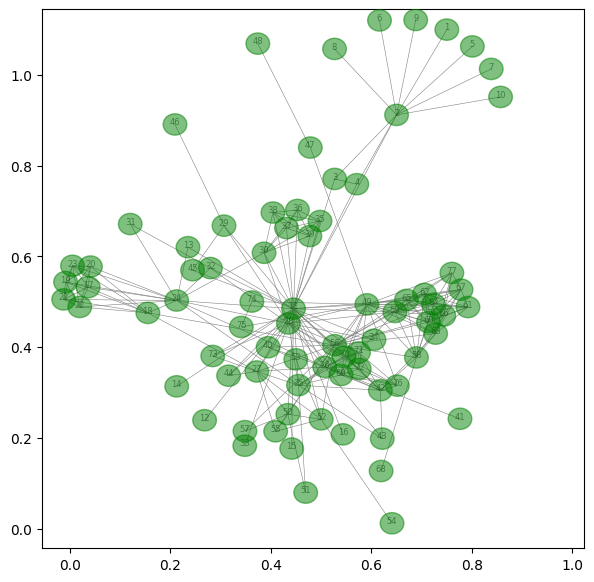

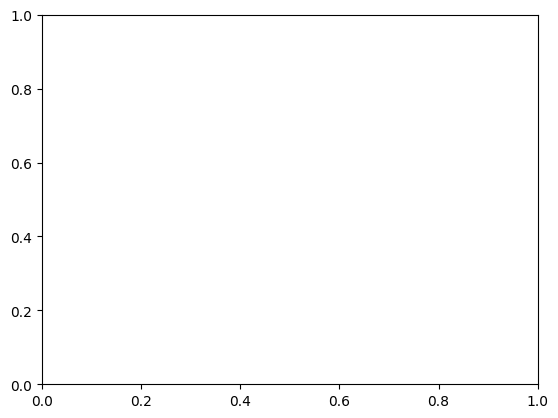

In [149]:

g.random_layout()
g.spring_embedder_f(ideal_length=.08, gravitational_constant=.1,magnetic_constant=.1)
g.return_fig()


In [127]:
def magnetic_forces(self, magnetic_constant):
    forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
    field_direction = np.array([0, 1])  # use [1, 0] for a horizontal field

    for u, v in self.edges.keys():
        delta = np.array(self.nodes[v].circle.center) - np.array(self.nodes[u].circle.center)
        edge_direction = delta / (np.linalg.norm(delta) + 1e-6)
        cos_theta = np.dot(edge_direction, field_direction)
        angle = np.arccos(np.clip(cos_theta, -1, 1))
        magnetic_force_magnitude = magnetic_constant * (1 - cos_theta)
        # Calculate perpendicular direction to the edge direction to apply force
        perpendicular_dir = np.array([-edge_direction[1], edge_direction[0]])
        magnetic_force = magnetic_force_magnitude * perpendicular_dir

        forces[u] += magnetic_force
        forces[v] -= magnetic_force
    return forces



def gravitational_forces(self, center_point, gravitational_constant):
    forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
    for node_id, node in self.nodes.items():
        delta = center_point - np.array(node.circle.center)

        distance = np.linalg.norm(delta)
        grav_force = gravitational_constant * delta
        forces[node_id] += grav_force / distance if distance > 0 else 0
    return forces


def spring_embedder_f(self, ideal_length=.1, K=100, epsilon=1e-4, delta=.1, gravitational_constant=None, magnetic_constant=None):
        center_point = np.array([0.5, 0.5])
        t = 0
        cooling_factor = 0.95
        min_delta = 0.00001

        while t < K:
            rep_forces = self.repulsive_forces_1(ideal_length)
            attr_forces = self.attractive_forces_1(ideal_length)
            grav_forces = self.gravitational_forces(center_point, gravitational_constant) if gravitational_constant else 0 #Gravity
            mag_forces = self.magnetic_forces(magnetic_constant) if mag_forces else 0 #magnetic



            for node_id, node in self.nodes.items():
                net_force = rep_forces[node_id] + attr_forces[node_id] + grav_forces[node_id] + mag_forces[node_id] #+gravity/magnetic

                displacement = np.clip(delta * net_force, -delta, delta)
                node.circle.center += displacement
                self.min_max_x = np.array([min(node.circle.center[0],self.min_max_x[0]),
                                               max(node.circle.center[0],self.min_max_x[1])])
                self.min_max_y = np.array([min(node.circle.center[1],self.min_max_y[0]),
                                               max(node.circle.center[1],self.min_max_y[1])])

            delta = max(min_delta, cooling_factor * delta)

            max_force = max(np.linalg.norm(node.circle.center) for node in self.nodes.values())
            if max_force < epsilon:
                break

            t += 1